# LSTM

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to handle long-term dependencies, as well as non-linear relationships, in time series data. This method can be computationally expensive and requires preprocessing the data to properly capture its sequentiality. We use two LSTM layers and a dense layer, and train for 100 epochs. We measure the reconstruction error using mean squared error and find that a threshold of 13x the median error works best.

In [33]:
# import necessary dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MSE

In [34]:
data = pd.read_csv('drive/My Drive/intc_data.csv')

In [35]:
# convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.to_period('M').astype(str)
print(data['Date'])

0       1985-01
1       1985-01
2       1985-01
3       1985-01
4       1985-01
         ...   
7559    2014-12
7560    2014-12
7561    2014-12
7562    2014-12
7563    2014-12
Name: Date, Length: 7564, dtype: object


<ipython-input-35-93c936101c8a>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.to_period('M').astype(str)


In [36]:
# Indicators to consider
indicators = ['Volume', 'SMA_50', 'RSI', 'MACD', 'Upper_BB', 'Lower_BB']
# Normalize the features
scaler = MinMaxScaler()
data[indicators] = scaler.fit_transform(data[indicators])

In [37]:
# Prepare the data
features = data[indicators]
time_steps = 1

X_train = features.values[:-time_steps].reshape(features.shape[0] - time_steps, time_steps, features.shape[1])
y_train = features.values[time_steps:]

# Define the LSTM model
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(time_steps, features.shape[1])),
    LSTM(units=32),
    Dense(features.shape[1], activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Predict reconstructions
reconstructions = model.predict(X_train)

# Calculate reconstruction error
errors = np.mean((X_train - reconstructions)**2, axis=1)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0727
Epoch 2/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019
Epoch 4/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017
Epoch 5/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016
Epoch 6/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 7/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 8/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 9/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0013
Epoch 10/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013
Epoch 11/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 12/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 13/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 14/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 15/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

In [51]:
# Identify outliers based on a threshold
threshold = 13 * np.median(errors)

# Identify outliers
outliers = data[1:][errors > threshold]

In [52]:
print(outliers.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 2097 to 3979
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          38 non-null     object 
 1   Open          38 non-null     float64
 2   High          38 non-null     float64
 3   Low           38 non-null     float64
 4   Close         38 non-null     float64
 5   Volume        38 non-null     float64
 6   Dividends     38 non-null     float64
 7   Stock Splits  38 non-null     float64
 8   Return        38 non-null     float64
 9   SMA_50        38 non-null     float64
 10  EMA_20        38 non-null     float64
 11  WMA_30        38 non-null     float64
 12  RSI           38 non-null     float64
 13  Upper_BB      38 non-null     float64
 14  Lower_BB      38 non-null     float64
 15  MACD          38 non-null     float64
 16  Signal_Line   38 non-null     float64
dtypes: float64(16), object(1)
memory usage: 5.3+ KB
None


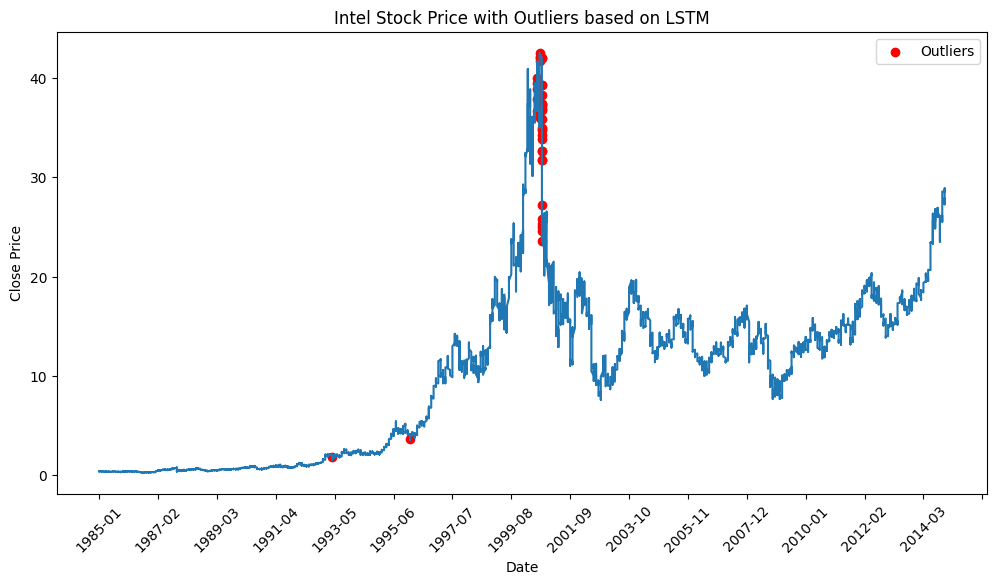

In [53]:
# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'])
plt.scatter(outliers['Date'], outliers['Close'], color='red', label='Outliers')
plt.title('Intel Stock Price with Outliers based on LSTM')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(25))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

Similarly to the autoencoder, this method primarily identifies data points that surround the Dot-Com Crash. This is another model that aims to capture the non-linear relationships within the data and yields promising results.